<a href="https://colab.research.google.com/github/Guillaume-Cr/Colab/blob/main/TripletLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import shutil

zip_path = 'drive/MyDrive/dogs.zip'
extract_path = '/content/dogs'
try:
    shutil.unpack_archive(zip_path, extract_path)
    print(f"Successfully extracted using shutil to {extract_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully extracted using shutil to /content/dogs


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import random
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class TripletImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_folders=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

        if num_folders and num_folders < len(self.classes):
            self.classes = random.sample(self.classes, num_folders)

        self.image_paths = []
        self.labels = []
        for label in self.classes:
            class_dir = os.path.join(root_dir, label)
            label_name = label.split('-')[1]  # Extract label name
            for img in os.listdir(class_dir):
                if img.endswith(('png', 'jpg', 'jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img))
                    self.labels.append(label_name)

        self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0] for label in set(self.labels)}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        anchor_path = self.image_paths[idx]
        anchor = Image.open(anchor_path).convert('RGB')
        anchor_label = self.labels[idx]

        positive_index = idx
        while positive_index == idx:
            positive_index = np.random.choice(self.label_to_indices[anchor_label])
        positive_path = self.image_paths[positive_index]
        positive = Image.open(positive_path).convert('RGB')

        negative_label = np.random.choice(list(set(self.labels) - {anchor_label}))
        negative_index = np.random.choice(self.label_to_indices[negative_label])
        negative_path = self.image_paths[negative_index]
        negative = Image.open(negative_path).convert('RGB')

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root_dir = '/content/dogs/images/Images'  # Root directory containing class subfolders
dataset = TripletImageDataset(root_dir=root_dir, transform=transform, num_folders=12)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


torch.Size([3, 224, 224])


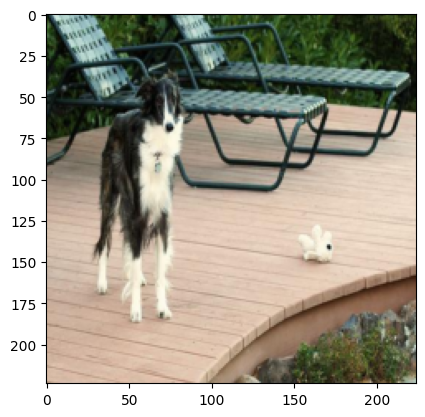

In [ ]:
# prompt: Check if the CustomImageDataset is able to get the image nicely

# Get a sample image and label
anchor, positive, negative = dataset[0]

# Print the shape of the image tensor
print(anchor.shape)  # Expected output: torch.Size([3, 224, 224])

# If you want to display the image, you can use matplotlib
import matplotlib.pyplot as plt

# Unnormalize the image (if you want to display it)
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

unnormalized_image = unnormalize(anchor.clone(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Convert the tensor to a numpy array and transpose dimensions
image_np = unnormalized_image.numpy().transpose((1, 2, 0))

# Display the image
plt.imshow(image_np)
plt.show()


In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Identity()  # Remove the final classification layer

    def forward(self, x):
        return self.model(x)

model = EmbeddingNet()

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        positive_distance = (anchor - positive).pow(2).sum(1)  # Squared L2 distance
        negative_distance = (anchor - negative).pow(2).sum(1)  # Squared L2 distance
        losses = torch.relu(positive_distance - negative_distance + self.margin)
        return losses.mean()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        anchor, positive, negative = batch  # Assuming your dataset yields triplets
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()
        anchor_embedding = model(anchor)
        positive_embedding = model(positive)
        negative_embedding = model(negative)

        loss = loss_fn(anchor_embedding, positive_embedding, negative_embedding)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# Example training loop
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    epoch_loss = train_epoch(model, dataloader, TripletLoss(), optimizer, device)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")

print("Training complete")

Epoch 1/10, Loss: 11.461126096664913
Epoch 2/10, Loss: 1.1748400441710911
Epoch 3/10, Loss: 0.6984242380611481
Epoch 4/10, Loss: 0.4737970574744164
Epoch 5/10, Loss: 0.4239716193387433
Epoch 6/10, Loss: 0.33459244656657416
Epoch 7/10, Loss: 0.2787779052224424
Epoch 8/10, Loss: 0.26036551121681456
Epoch 9/10, Loss: 0.23113769647620974
Epoch 10/10, Loss: 0.18142703157805262
Training complete


In [ ]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_folders=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

        if num_folders and num_folders < len(self.classes):
            self.classes = random.sample(self.classes, num_folders)

        self.image_paths = []
        self.labels = []
        self.image_filenames = []  # Store image file names

        for label in self.classes:
            class_dir = os.path.join(root_dir, label)
            label_name = label.split('-')[1]  # Extract label name
            for img in os.listdir(class_dir):
                if img.endswith(('png', 'jpg', 'jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img))
                    self.labels.append(label_name)
                    self.image_filenames.append(img)  # Store image file names

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        filename = self.image_filenames[idx]  # Get image file name

        if self.transform:
            image = self.transform(image)

        return image, label, img_path  # Return image, label, and image path


In [ ]:
import torch
import numpy as np

def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []
    image_paths = []
    with torch.no_grad():
        for batch in dataloader:
            images, batch_labels, paths = batch
            images = images.to(device)
            batch_embeddings = model(images).cpu().numpy()
            embeddings.append(batch_embeddings)
            labels.extend(batch_labels)
            image_paths.extend(paths)
    return np.vstack(embeddings), np.array(labels), image_paths

In [ ]:

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def visualize_embeddings(embeddings, labels, num_samples=1000):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings[:num_samples])

    # Use LabelEncoder to convert string labels to numeric codes
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels[:num_samples])

    # Get unique labels for legend
    unique_labels = label_encoder.classes_

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels_encoded, cmap='viridis')

    # Create legend handles and labels
    legend_handles = scatter.legend_elements()[0]
    legend_labels = unique_labels

    plt.legend(legend_handles, legend_labels)
    plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root_dir = '/content/dogs/images/Images'  # Root directory containing class subfolders
single_image_dataset = ImageDataset(root_dir=root_dir, transform=transform, num_folders=12)
single_image_dataloader = DataLoader(single_image_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Extract embeddings
embeddings, labels, paths = extract_embeddings(model, single_image_dataloader, device)

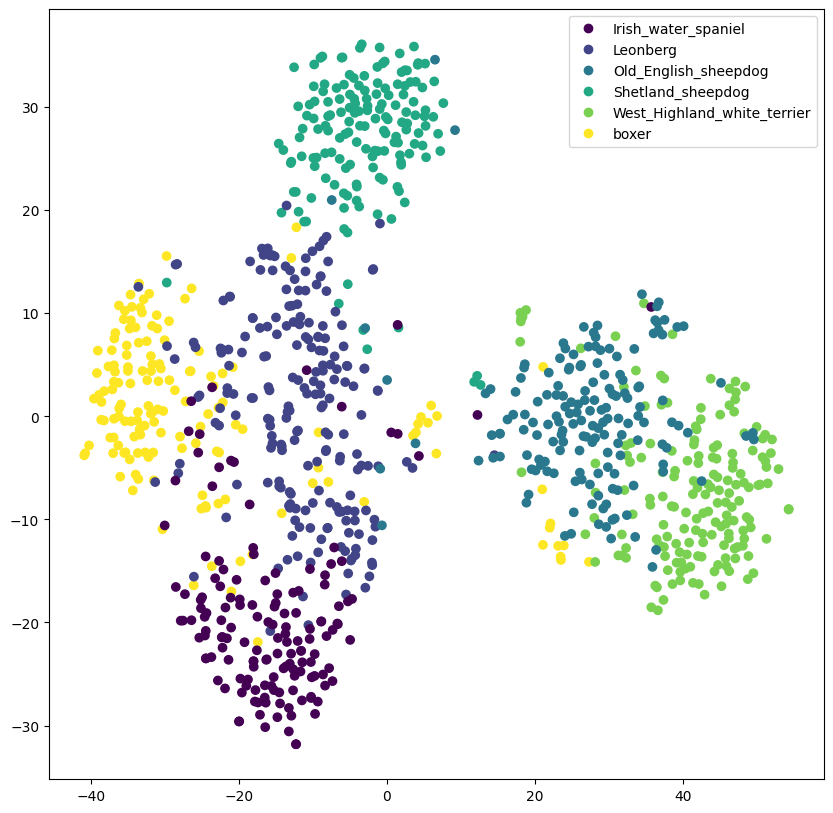

In [ ]:
# Visualize embeddings
visualize_embeddings(embeddings, labels)

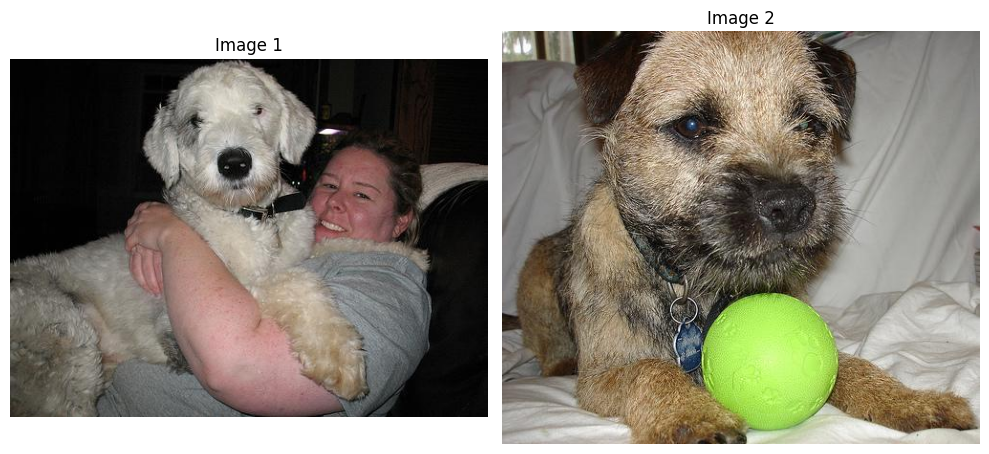

Similarity: 0.7665602564811707, Labels: Old_English_sheepdog, Border_terrier


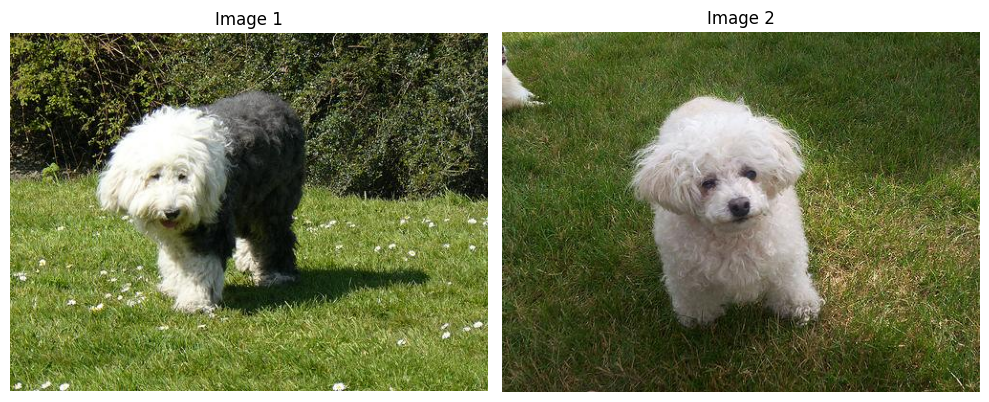

Similarity: 0.7787765860557556, Labels: Old_English_sheepdog, toy_poodle


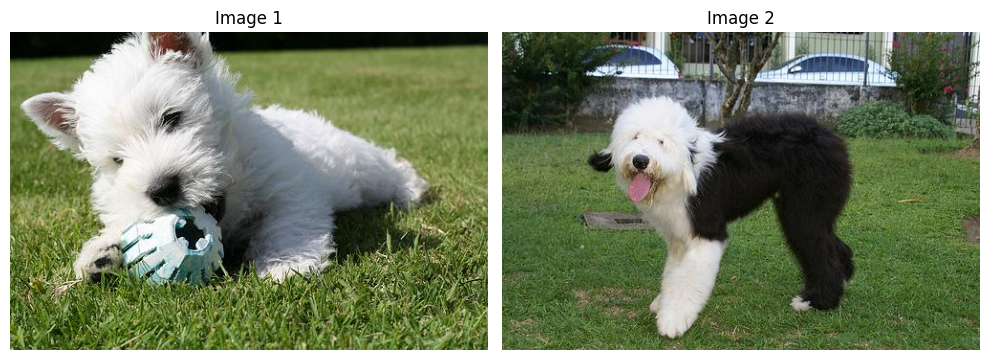

Similarity: 0.7849822640419006, Labels: West_Highland_white_terrier, Old_English_sheepdog


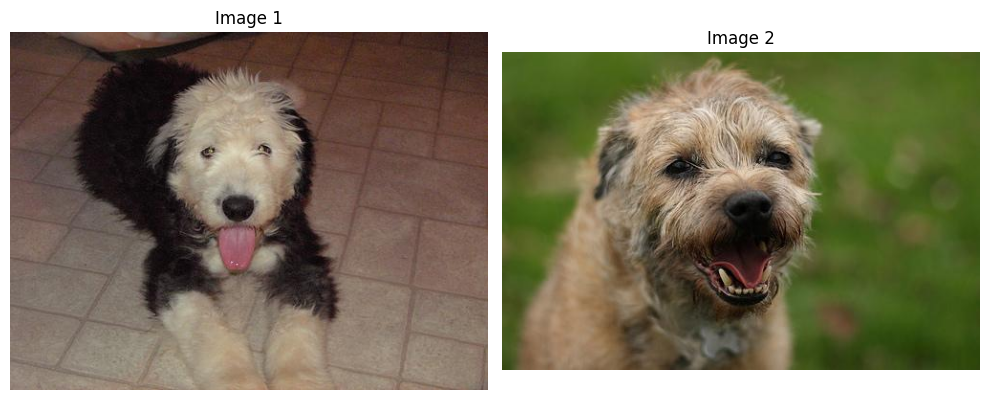

Similarity: 0.8039118051528931, Labels: Old_English_sheepdog, Border_terrier


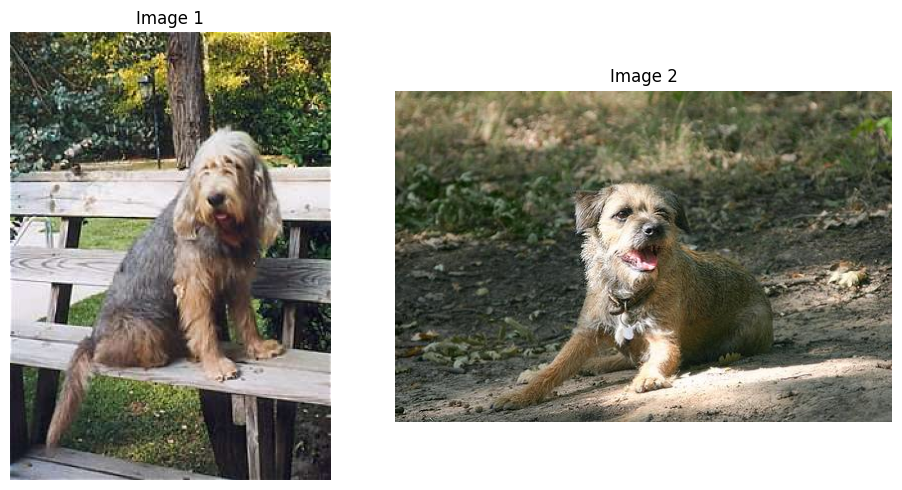

Similarity: 0.8042105436325073, Labels: otterhound, Border_terrier


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Example function to calculate similarity (you might use distance metrics like Euclidean, cosine similarity, etc.)
def calculate_similarity(embedding1, embedding2):
    return np.linalg.norm(embedding1 - embedding2)

# Example function to find pairs of images with close embeddings but different labels
def find_closest_embedding_pairs(embeddings, labels, image_paths, n=5):
    num_samples = len(embeddings)
    pairs = []

    # Calculate pairwise similarities and check labels
    for i in range(num_samples):
        for j in range(i + 1, num_samples):
            if labels[i] != labels[j]:
                similarity = calculate_similarity(embeddings[i], embeddings[j])
                pairs.append((i, j, similarity))

    # Sort pairs by similarity (ascending order)
    pairs.sort(key=lambda x: x[2])  # Sorting based on similarity (x[2] is the similarity value)

    # Filter to get n closest pairs with different labels
    closest_pairs = []
    for pair in pairs:
        index1, index2, similarity = pair
        if len(closest_pairs) >= n:
            break
        closest_pairs.append((index1, index2, similarity, image_paths[index1], image_paths[index2]))

    return closest_pairs

# Example visualization function
def visualize_image_pair(image1_path, image2_path):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    image1 = Image.open(image1_path)
    image2 = Image.open(image2_path)
    ax1.imshow(image1)
    ax1.set_title('Image 1')
    ax1.axis('off')
    ax2.imshow(image2)
    ax2.set_title('Image 2')
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming embeddings, labels, and image_paths are available
close_pairs = find_closest_embedding_pairs(embeddings, labels, paths, n=5)

# Visualize a few pairs
for pair in close_pairs:
    index1, index2, similarity, image1_path, image2_path = pair
    visualize_image_pair(image1_path, image2_path)
    print(f"Similarity: {similarity}, Labels: {labels[index1]}, {labels[index2]}")

